# Performance Analysis

This notebook visualizes performance analysis of LADDS runs

## Inputs
- CSV containing Simulation timers (manually parsed from LADDS cli output)

## Outputs
- plots

## 20 Year run

- Single node
- OpenMP only
- 16k particles

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib widget

sns.set_theme()

In [2]:
# csv containing one row per LADDS output file and one column for each simulation timer
df20years_runs = pd.read_csv('../results/simulationTimers/LADDS28_year_00-20.csv')

In [3]:
df20years_runs

,Filename,Total,Initialization,Simulation,Integrator,Constellation Insertion,Collision Detection,Collision Writer,Container Update,Output
0,LADDS28_375184_year_00-06.out,238682.599,0.259,238682.340,145439.231,1.340,51834.727,3.138,6549.981,627.136
1,LADDS28_376468_year_06-12.out,234791.336,106.914,234684.422,144997.577,1.165,47323.754,4.266,6614.051,1635.461
2,LADDS28_377725_year_12-18.out,234667.035,82.055,234584.980,146739.313,1.224,45073.968,4.753,6571.918,1677.210
3,LADDS28_378655_year_18-20.out,77568.844,262.956,77305.888,48455.981,0.416,14593.465,1.483,2181.963,533.318


In [4]:
# sum columns, throw away filenames, sort
df20years = df20years_runs.sum()[1:]
# calculate and add burn up time
if 'Resolving Burn ups' not in df20years or 'Burnup Detection' not in df20years:
    df20years['Burnup Detection'] = (df20years['Simulation'] - df20years['Integrator'] - df20years[
        'Collision Detection'] - df20years['Container Update'] - df20years['Output']) * .999
# filter out uninteresting stuff (e.g. everything smaller than initialization)
df20years = df20years.where(df20years > 100).dropna()
# convert to hours
df20years = df20years / (60 * 60)
df20years = df20years.sort_values(ascending=False)

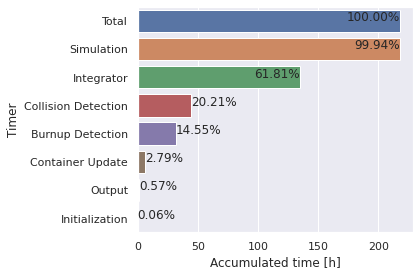

In [5]:
ax = sns.barplot(x=df20years.values,
                 y=df20years.keys().values,
                 )
plt.xlabel("Accumulated time [h]")
plt.ylabel("Timer")
# label all bars
for index, value in enumerate(df20years.values):
    # label inside if bar is long enough else outside
    ax.text(value,
            index,
            # f"{value:.2f} ({value / dfSum[0] * 100:.2f}%)",
            f"{value / df20years[0] * 100:.2f}%",
            # f"{value:.2f}",
            horizontalalignment='right' if value > 50 else 'left',
            )
plt.tight_layout()
plt.savefig('runtime.pdf')

### Compare different optimization steps of the burnup detection

In [6]:
# read the baseline and append all others
# each csv contains one row from a LADDS output file and one column for each simulation timer
dfBurnUps = pd.concat([pd.read_csv('../results/burnUpTuning/noParallelization.csv'),
                       pd.read_csv('../results/burnUpTuning/parallelization.csv'),
                       ],
                      ignore_index=True)

# dfBurnUps[Filename["parallelization.out"]]
# dfBurnUps[1:][:2].values
plotMe = dfBurnUps.melt(id_vars='Filename')

totalSeq = plotMe.query('Filename == "seq" and variable == "Total"').value
totalPar = plotMe.query('Filename == "par" and variable == "Total"').value
plotMe['valuePercent'] = pd.concat([plotMe[plotMe.Filename == 'seq'].value / totalSeq[0],
                                    plotMe[plotMe.Filename == 'par'].value / totalPar[1]])
plotMe

,Filename,variable,value,valuePercent
0,seq,Total,13.217,1.000000
1,par,Total,11.441,1.000000
2,seq,Resolving Burn ups,1.967,0.148823
3,par,Resolving Burn ups,0.130,0.011363
4,seq,Initialization,0.203,0.015359
5,par,Initialization,0.195,0.017044
6,seq,Simulation,13.014,0.984641
7,par,Simulation,11.246,0.982956
8,seq,Integrator,8.043,0.608534
9,par,Integrator,8.061,0.704571


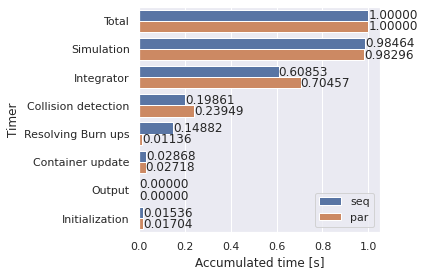

In [7]:
ax = sns.barplot(data=plotMe,
                 x='valuePercent',
                 y='variable',
                 orient='h',
                 order=['Total', 'Simulation', 'Integrator', 'Collision detection', 'Resolving Burn ups',
                        'Container update', 'Output', 'Initialization'],
                 hue='Filename',
                 )
# label all bars
ax.bar_label(ax.containers[-1], fmt="%.5f", label_type='edge')
ax.bar_label(ax.containers[-2], fmt='%.5f', label_type='edge')
plt.xlabel("Accumulated time [s]")
plt.ylabel("Timer")
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('runtime_seqVsPar.pdf')

## MPI Scaling

In [38]:
dfMPIScaling = pd.read_csv('../results/mpiScaling/withoutTuning/mpiScaling.csv')

dfMPIScaling

,Filename,MPI Ranks,OpenMP Threads per Rank,Container,desiredCellsPerDimension,Total (ranks accumulated),Initialization,Simulation,Integrator,Resolving Burn ups,...,Communication,Collision detection,Collision detection immigrants,Collision detection emmigrants,Collision writer,Evasion writer,Container update,Output,Total (wall-time),One iteration
0,LADDS04_interactive.out,7,4,LinkedCells,25.0,5514.473,57.120,5457.352,853.782,27.464,...,746.237,3576.018,16.370,24.174,0.008,0.010,212.287,0.049,787.844,0.390
1,LADDS04_483679.out,14,4,LinkedCells,25.0,3742.145,106.503,3635.642,817.723,25.975,...,670.278,1858.548,16.444,33.012,0.013,0.016,211.387,0.098,267.338,0.130
2,LADDS04_483678.out,28,4,LinkedCells,25.0,2983.984,230.978,2753.005,805.857,29.307,...,668.758,960.606,15.765,51.778,0.015,0.016,217.648,0.208,106.624,0.049
3,LADDS04_119998.out,56,4,LinkedCells,25.0,3065.040,425.176,2639.864,863.091,33.225,...,807.307,537.818,18.210,93.558,0.021,0.019,257.257,1.497,54.810,0.023
4,LADDS04_119997.out,112,4,LinkedCells,25.0,3704.705,867.547,2837.158,967.877,40.678,...,910.311,364.567,25.434,163.588,0.037,0.034,330.468,7.177,33.163,0.012
5,LADDS04_119996.out,224,4,LinkedCells,25.0,6331.167,2901.384,3429.783,1172.286,52.845,...,1074.911,321.498,35.939,239.772,0.071,0.065,454.792,17.818,28.287,0.007
6,LADDS04_119995.out,448,4,LinkedCells,25.0,11240.056,4910.668,6329.388,1385.022,69.316,...,2419.942,361.291,49.206,290.942,0.136,0.122,648.617,40.507,23.123,0.005
7,LADDS04_485107.out,7,4,VarVerletListsAsBuild,11.0,9880.665,52.180,9828.486,714.498,24.666,...,5360.891,3465.587,35.325,39.076,0.009,0.009,183.978,3.332,1411.807,0.702
8,LADDS04_485106.out,14,4,VarVerletListsAsBuild,11.0,5598.896,107.440,5491.456,754.741,26.872,...,2581.724,1859.063,30.428,45.644,0.014,0.017,187.619,3.167,400.033,0.196
9,LADDS04_485105.out,28,4,VarVerletListsAsBuild,11.0,3440.436,222.936,3217.500,712.989,27.796,...,1227.319,960.810,25.671,61.675,0.018,0.018,195.038,2.924,122.913,0.057


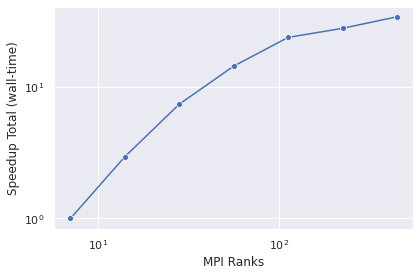

In [77]:
thisData = dfMPIScaling.query('Container == "LinkedCells"').copy()

for s in ['Total (wall-time)']:
    thisData['Speedup ' + s] = thisData.query('`MPI Ranks` == 7')[s][0] / thisData[s]

ax = sns.lineplot(
    data=thisData,
    x='MPI Ranks',
    y='Speedup Total (wall-time)',
    marker='o',
)
ax.loglog(base=2)
plt.tight_layout()
X_plot = np.linspace(7, 448, 10)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='gray')
# plt.savefig('SpeedupWallTime.pdf')
plt.savefig('SpeedupWallTime.png', dpi=300)

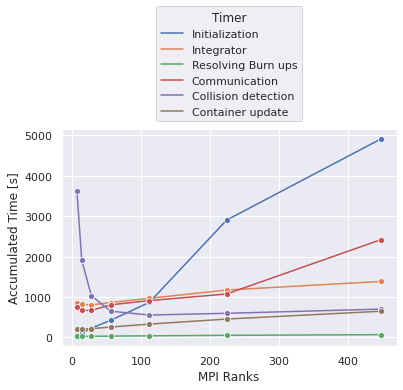

In [93]:
thisData = dfMPIScaling.query('Container == "LinkedCells"').copy()
thisData['Collision detection'] = thisData['Collision detection'] + thisData['Collision detection immigrants'] + thisData['Collision detection emmigrants']
thisData = thisData.melt(
    id_vars=['MPI Ranks'],
    value_vars=[
        'Initialization',
        'Integrator',
        'Resolving Burn ups',
        'Communication',
        'Collision detection',
        'Container update',
    ],
    value_name='Accumulated Time [s]',
    var_name='Timer',
)
ax = sns.lineplot(
    data=thisData,
    x='MPI Ranks',
    y='Accumulated Time [s]',
    hue='Timer',
    marker='o',
)
sns.move_legend(ax, "center", bbox_to_anchor=(0.5, 1.3))
# plt.savefig('StrongscalingTimiers.pdf', bbox_inches='tight')
plt.savefig('StrongscalingTimiers.png', bbox_inches='tight', dpi=300)